# Interpret LightGBM Classifier with SHAP: Spaceship Titanic Dataset

## Introduction

This notebook demonstrates how to utilize SHAP (SHapley Additive exPlanations) to interpret complex gradient-boosted models, specifically LightGBM. The purpose is to make the results of these models more interpretable to both yourself and stakeholders. SHAP provides a unified framework to explain the output of any machine learning model, helping you understand the contribution of each feature to the predictions.

## Table of Contents

1. [Data Preparation](#data-preparation)
   - [Import Data and Modules](#import-data-and-modules)
   - [Feature Engineering](#feature-engineering)
   - [Data Cleaning](#data-cleaning)
2. [Modeling](#modeling)
   - [Data Preprocessing for Modeling](#data-preprocessing-for-modeling)
   - [Model Training](#model-training)
   - [Model Evaluation](#model-evaluation)
   - [Submit Predictions](#submit-predictions)
3. [Interpretability](#interpretability)
   - [SHAP Analysis](#shap-analysis)

# 1) Data Preparation -------------------------
<a id="data-preparation"></a>

## Data Description

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

> * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
> * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.<br>
> * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.<br>
> * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
> * **Destination** - The planet the passenger will be debarking to.<br>
> * **Age** - The age of the passenger.<br>
> * **VIP** - Whether the passenger has paid for special VIP service during the voyage.<br>
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br>
> * **Name** - The first and last names of the passenger.<br>
> * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.<br>

## Import Data and Modules
<a id="import-data-and-modules"></a>

In [1]:
# Base modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Text modules
from nltk.corpus import names
from nltk.classify import NaiveBayesClassifier
import nltk

# Modeling and evaluation
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
import shap
import os

In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train['set'] = "train"
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test['set'] = "test"
df = pd.concat([train, test], ignore_index=False)

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,set
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,train
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,train
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,train
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,train


## Feature Engineering
<a id="feature-engineering"></a>

### 1. Create Group vs solo Feature

In [4]:
df['PassengerGroup'] = df['PassengerId'].str[:4]

group_counts = df['PassengerGroup'].value_counts().sort_index()

df['GroupSize'] = df.groupby('PassengerGroup')['PassengerId'].transform('count')

In [5]:
df['solo_traveler'] = df['GroupSize'].apply(lambda x: True if x > 1 else False)

In [6]:
df['GroupSize'].value_counts()

GroupSize
1    7145
2    2590
3    1506
4     616
5     380
7     329
6     252
8     152
Name: count, dtype: int64

### 2. Feature Engineer Cabin Data

#### 2.1) Break Out Cabin Into Deck / Number / Side

In [7]:
def split_cabin(cabin):
    if pd.isna(cabin):
        return pd.Series([None, None, None])
    parts = cabin.split('/')
    deck = parts[0]
    number = parts[1]
    side = 'Port' if parts[2] == 'P' else 'Starboard'
    return pd.Series([deck, number, side])

df[['cabin_deck', 'cabin_number', 'cabin_side']] = df['Cabin'].apply(split_cabin)

#### 2.2) Bin Cabin Number

In [8]:
# Convert the cabin_number column to numeric
df['cabin_number'] = pd.to_numeric(df['cabin_number'], errors='coerce')

# Convert the maximum value to an integer
max_cabin_number = int(df['cabin_number'].max())

# Bin the cabin_number column into groups of 300 starting at 0
bins = range(0, max_cabin_number + 50, 50)
labels = range(1, len(bins))  # Numeric labels starting from 1
df['cabin_region'] = pd.cut(df['cabin_number'], bins=bins, labels=labels, right=False)

#### 2.3) Group Decks into Categories

In [9]:
# Define the new combined deck categories based on the provided bins
def combined_deck_category(deck):
    if deck == 'A':
        return 'top_deck'
    elif deck in ['B', 'C']:
        return 'upper_deck'
    elif deck in ['D', 'E']:
        return 'mid_deck'
    elif deck in ['F', 'G']:
        return 'lower_deck'
    elif deck == 'T':
        return 'bottom_deck'
    else:
        return np.nan

# Apply the function to create the new combined deck categories
df['cabin_deck'] = df['cabin_deck'].apply(combined_deck_category)

In [10]:
df[['cabin_deck', 'cabin_side', 'cabin_region']].head()

,cabin_deck,cabin_side,cabin_region
0,upper_deck,Port,1
1,lower_deck,Starboard,1
2,top_deck,Starboard,1
3,top_deck,Starboard,1
4,lower_deck,Starboard,1


#### 2.4) Create Relative Risk Feature for Cabin Location

In [11]:
# Ensure columns are strings for concatenation
df['cabin_deck'] = df['cabin_deck'].astype(str)
df['cabin_region'] = df['cabin_region'].astype(str)

# Create the new feature by combining 'cabin_deck' and 'cabin_region'
df['cabin_location'] = df['cabin_deck'] + "_" + df['cabin_region']

# Calculate the average share of 'Transported' for the combined feature
average_share_cabin_location = df[df['set'] == 'train'].groupby('cabin_location')['Transported'].mean()

# Handle missing values by calculating the average share for non-missing parts
average_share_deck = df[df['set'] == 'train'].groupby('cabin_deck')['Transported'].mean()
average_share_region = df[df['set'] == 'train'].groupby('cabin_region')['Transported'].mean()

# Drop columns to avoid conflicts before merging
df = df.drop(columns=['average_share_cabin_location', 'average_share_deck', 'average_share_region'], errors='ignore')

# Merge the calculated average share back to the dataframe
df = df.merge(average_share_cabin_location.rename('average_share_cabin_location'), on='cabin_location', how='left')
df = df.merge(average_share_deck.rename('average_share_deck'), on='cabin_deck', how='left')
df = df.merge(average_share_region.rename('average_share_region'), on='cabin_region', how='left')

# Fill missing values in the combined feature with the average of the non-missing parts
df['average_share_cabin_location'] = df['average_share_cabin_location'].combine_first((df['average_share_deck'] + df['average_share_region']) / 2)

# Convert average_share_cabin_location to float
df['average_share_cabin_location'] = df['average_share_cabin_location'].astype(float)

# Ensure no division by zero errors
df['average_share_cabin_location'] = df['average_share_cabin_location'].clip(0.0001, 0.9999)

# Calculate the log of relative risk for each person
df['cabin_location_relative_risk'] = np.log(df['average_share_cabin_location'] / (1 - df['average_share_cabin_location']))

In [12]:
# Display the first few rows of the updated dataframe
df[['PassengerId', 'cabin_location', 'average_share_cabin_location', 'cabin_location_relative_risk']].head()

,PassengerId,cabin_location,average_share_cabin_location,cabin_location_relative_risk
0,0001_01,upper_deck_1,0.680365,0.755451
1,0002_01,lower_deck_1,0.487654,-0.049393
2,0003_01,top_deck_1,0.486726,-0.053110
3,0003_02,top_deck_1,0.486726,-0.053110
4,0004_01,lower_deck_1,0.487654,-0.049393


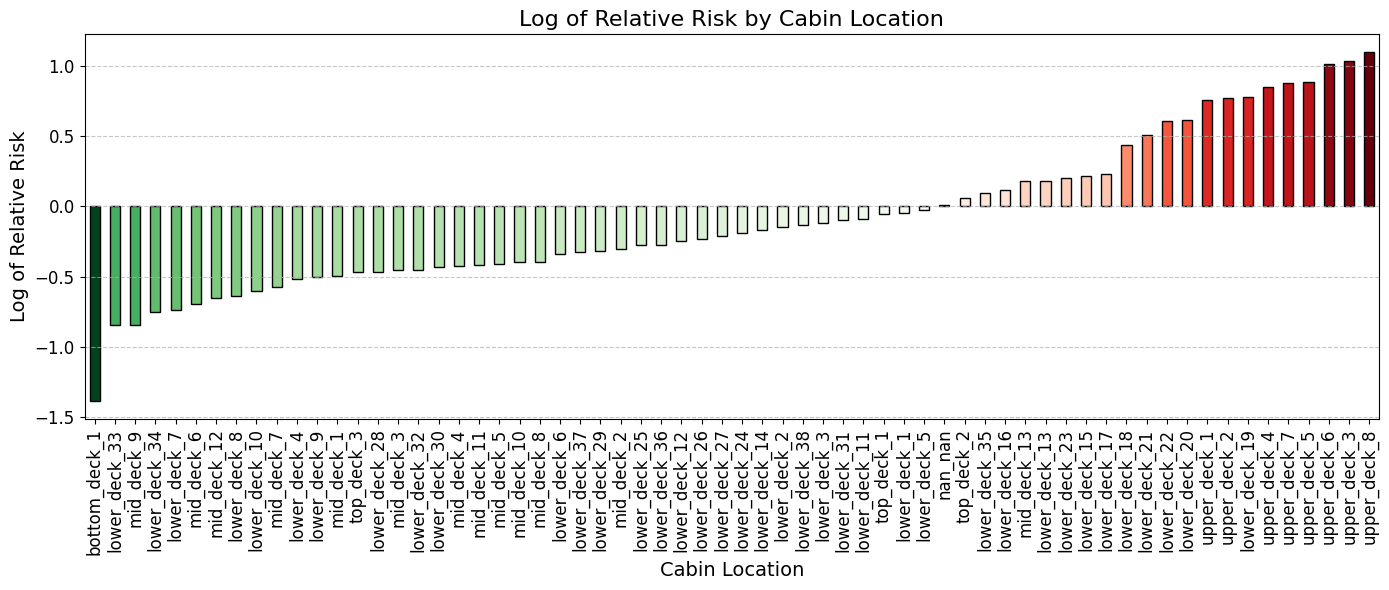

In [13]:
# Group by cabin_location and calculate the mean of log_relative_risk
log_risk_by_cabin_location = df.groupby('cabin_location')['cabin_location_relative_risk'].mean().sort_values()

# Define the colormap function
def get_color(val):
    if val > 0:
        return plt.cm.Reds(val / max(log_risk_by_cabin_location))
    else:
        return plt.cm.Greens(abs(val) / abs(min(log_risk_by_cabin_location)))

# Apply the colormap
colors = log_risk_by_cabin_location.apply(get_color)

# Plotting
plt.figure(figsize=(14, 6))
log_risk_by_cabin_location.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Log of Relative Risk by Cabin Location', fontsize=16)
plt.xlabel('Cabin Location', fontsize=14)
plt.ylabel('Log of Relative Risk', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### 4. Infer Gender From First Name

In [14]:
nltk.download('names')

[nltk_data] Downloading package names to /usr/share/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [15]:
# Fill missing values in the 'Name' column with an empty string
df['Name'] = df['Name'].fillna('')

# Extract first names from the 'Name' column
def extract_first_name(name):
    return name.split()[0] if name else ''

df['first_name'] = df['Name'].apply(extract_first_name)

# Function to extract the last letter of a name as a feature
def gender_features(word):
    return {'last_letter': word[-1]}

In [16]:
# Prepare labeled names dataset
labeled_names = [(name, "male") for name in names.words("male.txt")] + [(name, "female") for name in names.words("female.txt")]
random.shuffle(labeled_names)

In [17]:
# Extract featuresets
featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names]

In [18]:
# Train the NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(featuresets)

# Set blanks and None values to NaN
df['first_name'] = df['first_name'].replace({'': np.nan, None: np.nan})

# Classify gender for the DataFrame and handle NaN values
df['gender'] = df['first_name'].apply(lambda x: classifier.classify(gender_features(x)) if pd.notna(x) else np.nan)

# Drop the temporary 'first_name' column if necessary
df.drop(columns=['first_name'], inplace=True)

### 5. Create Age Feature

In [19]:
# Create a new variable for age groups
def age_group(age):
    if age < 13:
        return 'Kid'
    elif age < 18:
        return 'Teen'
    else:
        return 'Adult'

# Apply the function to create a new column
df['Age_Group'] = df['Age'].apply(age_group)

In [20]:
df['Age_Group'].value_counts()

Age_Group
Adult    10706
Kid       1157
Teen      1107
Name: count, dtype: int64

## Data Cleaning
<a id="data-cleaning"></a>

### 1. Drop Columns

In [21]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,cabin_number,cabin_side,cabin_region,cabin_location,average_share_cabin_location,average_share_deck,average_share_region,cabin_location_relative_risk,gender,Age_Group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Port,1,upper_deck_1,0.680365,0.707733,0.526398,0.755451,male,Adult
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0.0,Starboard,1,lower_deck_1,0.487654,0.476368,0.526398,-0.049393,female,Adult
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0.0,Starboard,1,top_deck_1,0.486726,0.496094,0.526398,-0.053110,male,Adult
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0.0,Starboard,1,top_deck_1,0.486726,0.496094,0.526398,-0.053110,male,Adult
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1.0,Starboard,1,lower_deck_1,0.487654,0.476368,0.526398,-0.049393,female,Teen


In [22]:
drop_cols = ['Cabin',
             'average_share_region',
             'average_share_deck',
             'average_share_cabin_location',
             'cabin_region',
             'cabin_deck',
             'Name', 
             'PassengerGroup', 
             'Age', 
             'cabin_number', 
             'gender', 
             'GroupSize']

df.drop(columns=drop_cols, inplace=True)

In [23]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,set,solo_traveler,cabin_side,cabin_location,cabin_location_relative_risk,Age_Group
0,0001_01,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,train,False,Port,upper_deck_1,0.755451,Adult
1,0002_01,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,train,False,Starboard,lower_deck_1,-0.049393,Adult
2,0003_01,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,train,True,Starboard,top_deck_1,-0.053110,Adult
3,0003_02,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,train,True,Starboard,top_deck_1,-0.053110,Adult
4,0004_01,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,train,False,Starboard,lower_deck_1,-0.049393,Teen


### 2. Deal with Missing Values

#### 2.1) Impute Spending Columns

#### 2.2) Impute Age Group Randomly

#### 2.3) Impute Deck Level with LightGBM

#### 2.4) Impute CryoSleep Based on Spend

#### 2.5) Impute the rest of the missing features

#### 2.6) Display Clean Dataset

# 2) Modeling -------------------------
<a id="modeling"></a>

## Data Preprocessing for Modeling
<a id="data-preprocessing-for-modeling"></a>

### 1. Encode Categorical Features

In [24]:
label_encoders = {}
categorical_features = ['HomePlanet',
                        'Age_Group',
                        'solo_traveler',
                        'Age_Group',
                        'CryoSleep', 
                        'Destination', 
                        'VIP', 
                        'cabin_location',
                        'cabin_side']

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Ensure all columns are the correct data type
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [25]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,set,solo_traveler,cabin_side,cabin_location,cabin_location_relative_risk,Age_Group
0,0001_01,1,0,2,0,0.0,0.0,0.0,0.0,0.0,False,train,0,1,56,0.755451,0
1,0002_01,0,0,2,0,109.0,9.0,25.0,549.0,44.0,True,train,0,2,1,-0.049393,0
2,0003_01,1,0,2,1,43.0,3576.0,0.0,6715.0,49.0,False,train,1,2,53,-0.053110,0
3,0003_02,1,0,2,0,0.0,1283.0,371.0,3329.0,193.0,False,train,1,2,53,-0.053110,0
4,0004_01,0,0,2,0,303.0,70.0,151.0,565.0,2.0,True,train,0,2,1,-0.049393,2


### 2. Split the data into training and test set

In [26]:
# Split the data into training and validation sets
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

X = train_df.drop(columns=['Transported', 'set', 'PassengerId'])
y = train_df['Transported'].astype(int)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training
<a id="model-training"></a>

In [28]:
# Set the best hyperparameters
best_params = {
    'reg_lambda': 0.7517690720290097,
    'reg_alpha': 0.26609419337829127,
    'colsample_bytree': 0.6670508752583044,
    'subsample': 0.7760321887108744,
    'learning_rate': 0.02359746790033108,
    'n_estimators': 1704,
    'max_depth': 5,
    'min_child_weight': 9,
    'num_leaves': 48,
    'min_split_gain': 0.001398609784731401,
    'scale_pos_weight': 0.9920945544976784,
    'bagging_fraction': 0.4667650156863603,
    'feature_fraction': 0.5845211151773233,
    'boosting_type': 'gbdt',
    'verbose': -1
}

In [29]:
# Initialize the model with the best hyperparameters
model = lgb.LGBMClassifier(**best_params)

In [30]:
# Train the model
model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.4667650156863603,
               colsample_bytree=0.6670508752583044,
               feature_fraction=0.5845211151773233,
               learning_rate=0.02359746790033108, max_depth=5,
               min_child_weight=9, min_split_gain=0.001398609784731401,
               n_estimators=1704, num_leaves=48, reg_alpha=0.26609419337829127,
               reg_lambda=0.7517690720290097,
               scale_pos_weight=0.9920945544976784,
               subsample=0.7760321887108744, verbose=-1)

## Model Evaluation
<a id="model-evaluation"></a>

In [31]:
# Predictions
y_pred = model.predict(X_val)

# Evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.80448533640023
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       861
           1       0.80      0.81      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



## Submit Predictions
<a id="submit-predictions"></a>

In [32]:
# Submit Predictions
X_test = test_df.drop(columns=['PassengerId', 'set', 'Transported'])
test_predictions = model.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_predictions.astype(bool)
})

In [33]:
# Save the submission dataframe to a CSV file
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Transported
8693,0013_01,True
8694,0018_01,False
8695,0019_01,True
8696,0021_01,True
8697,0023_01,True


# 3) Interpretability -------------------------
<a id="interpretability"></a>

## SHAP Analysis
<a id="shap-analysis"></a>